Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


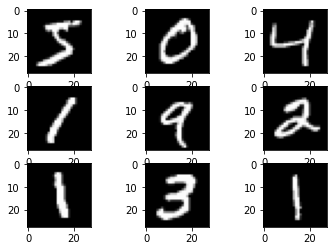

In [1]:
"""
Working with MNIST dataset to evaluate the performance of CNN model and use it to make predictions on new images.
"""

from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    
# show the figure
plt.show()

In [2]:
# load train and test dataset
def load_dataset():
	# load dataset
	(x_train, y_train), (x_test, y_test) = mnist.load_data()
	# reshape dataset to have a single channel
	x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
	x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
	# one hot encode target values
	y_train = to_categorical(y_train)
	y_test = to_categorical(y_test)
	return x_train, y_train, x_test, y_test

In [3]:

# scale pixels
def prep_pixels(train, test):
    # convert from int to float
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normailize 255 color values to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [4]:
# define CNN model
def define_model_v1():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # 0-9 digit categories
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# define CNN model with increased model depth
def define_model_v2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # 0-9 digit categories
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(x_data, y_data, n_folds=5):
    scores_v1, histories_v1, scores_v2, histories_v2 = list(), list(), list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(x_data):
        # define models
        model_v1 = define_model_v1()
        # select rows for train and test
        x_train, y_train, x_test, y_test = x_data[train_ix], y_data[train_ix], x_data[test_ix], y_data[test_ix]
        # fit model
        history_v1 = model_v1.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=0)
        # evaluate model
        _, acc_v1 = model_v1.evaluate(x_test, y_test, verbose=0)
        print('v1 acc --> %.3f' % (acc_v1 * 100.0))
        # stores scores
        scores_v1.append(acc_v1)
        histories_v1.append(history_v1)
    for train_ix, test_ix in kfold.split(x_data):
        # define models
        model_v2 = define_model_v2()
        # select rows for train and test
        x_train, y_train, x_test, y_test = x_data[train_ix], y_data[train_ix], x_data[test_ix], y_data[test_ix]
        # fit model
        history_v2 = model_v2.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=0)
        # evaluate model
        _, acc_v2 = model_v2.evaluate(x_test, y_test, verbose=0)
        print('v2 acc --> %.3f' % (acc_v2 * 100.0))
        # stores scores
        scores_v2.append(acc_v2)
        histories_v2.append(history_v2)
    return scores_v1, histories_v1, scores_v2, histories_v2

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics_v1(histories_v1, histories_v2):
    fig, axs = plt.subplots(2, 2, sharex=True)
    axs[0, 0].set_title('Loss')
    axs[0, 1].set_title('Loss')
    axs[1, 0].set_title('Accuracy')
    axs[1, 1].set_title('Accuracy')
    for i in range(len(histories_v1)):
        # v1
        # loss
        v1_loss, = axs[0, 0].plot(histories_v1[i].history['loss'], color='red', label='train')
        v1_val_loss, = axs[0, 1].plot(histories_v1[i].history['val_loss'], color='orange', label='test')
        # accuracy
        v1_acc, = axs[1, 0].plot(histories_v1[i].history['accuracy'], color='red', label='train')
        v1_val_acc, = axs[1, 1].plot(histories_v1[i].history['val_accuracy'], color='orange', label='test')
    for i in range(len(histories_v2)):
        # v2
        # loss
        v2_loss, = axs[0, 0].plot(histories_v2[i].history['loss'], color='green', label='train')
        v2_val_loss, = axs[0, 1].plot(histories_v2[i].history['val_loss'], color='blue', label='test')
        # accuracy
        v2_acc, = axs[1, 0].plot(histories_v2[i].history['accuracy'], color='green', label='train')
        v2_val_acc, = axs[1, 1].plot(histories_v2[i].history['val_accuracy'], color='blue', label='test')
    fig.legend((v1_loss, v1_val_loss, v2_loss, v2_val_loss), ('v1 training', 'v1 testing', 'v2 training', 'v2 testing'), 'upper center')
    plt.show

In [8]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    x_train, y_train, x_test, y_test = load_dataset()
    # prepare pixel data
    x_train, x_test = prep_pixels(x_train, x_test)
    # evaluate model
    scores_v1, histories_v1, scores_v2, histories_v2 = evaluate_model(x_train, y_train)
    print("-------------")
    # learning curves and summarize estimated performance
    summarize_diagnostics_v1(histories_v1, histories_v2)

v1 acc --> 98.575
v1 acc --> 98.650
v1 acc --> 98.492
v1 acc --> 98.817
v1 acc --> 98.692
v2 acc --> 98.992
v2 acc --> 99.033
v2 acc --> 98.950
v2 acc --> 99.267
v2 acc --> 99.033
-------------


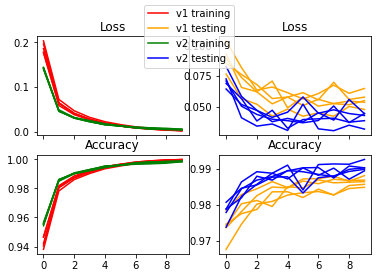

In [9]:
# run the test harness
run_test_harness()